Se importan las librerías que se usarán en este proyecto

In [55]:
import pandas as pd
import requests
import json
from urllib.parse import urlencode
import matplotlib.pyplot as plt
from datetime import date

A continuación se va a construir una URL para hacer una solicitud a una API web, para este caso SECOP II - Proveedores Registrados - Armenia (Quindío).

In [56]:
base_url = 'https://www.datos.gov.co/resource/56sy-nvip.json'
limit = 20000  
params = urlencode({'$limit': limit})
url = f'{base_url}?{params}'

Se hace una solicitud HTTP GET a la URL construida anteriormente utilizando la biblioteca requests. Luego, la informaciòn que está en formato JSON se debe transformar en un objeto de python, luego en una dataframe con pandas. Si la solicitud no fue exitosa, se indica que nos indique que hay un error en la solicitud a la API. 

In [57]:
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    directorio = pd.DataFrame(data)
else:
    print('Error en la solicitud a la API:', response.status_code)

Verificamos las dimensiones de la base de datos que acabamos de crear.

In [58]:
directorio.shape

(2507, 11)

Ahora revisamos las 11 columnas que componen la base de datos.

In [59]:
directorio.columns

Index(['nombre', 'nit', 'tipo_empresa', 'espyme', 'ubicacion',
       'fecha_creacion', 'pais', 'departamento', 'municipio',
       'codigo_categoria_principal', 'descripcion_categoria_principal'],
      dtype='object')

Se puede evidenciar que los nombres de las columnas para esta base de datos vienen con una parametrización, la fuente de datos de la que se está usando en este ejercicio nos muestra los Nombres de cada campo, estos nombres se encuentran en el archivo adjunto llamado 'Nombres columnas', vamos a realizar los respectivos reemplazos a continuación.

In [60]:
reemplazos_columnas = {'nombre': 'Nombre',
'nit':'NIT',
'tipo_empresa':'Tipo Empresa',
'espyme':'Es Pyme',
'ubicacion':'Ubicación',
'fecha_creacion':'Fecha Creación',
'pais':'Pais', 
'departamento':'Departamento', 
'municipio':'Municipio', 
'codigo_categoria_principal':'Codigo Categoria Principal', 
'descripcion_categoria_principal':'Descripcion Categoria Principal',                        
}

directorio.rename(columns=reemplazos_columnas, inplace=True)

Se comprueban los cambios realizados.

In [61]:
directorio.columns

Index(['Nombre', 'NIT', 'Tipo Empresa', 'Es Pyme', 'Ubicación',
       'Fecha Creación', 'Pais', 'Departamento', 'Municipio',
       'Codigo Categoria Principal', 'Descripcion Categoria Principal'],
      dtype='object')

Vamos a conocer el tipo de datos que contiene cada columna de la base de datos.

In [62]:
tipos_de_datos = directorio.dtypes

tipos_de_datos

Nombre                             object
NIT                                object
Tipo Empresa                       object
Es Pyme                            object
Ubicación                          object
Fecha Creación                     object
Pais                               object
Departamento                       object
Municipio                          object
Codigo Categoria Principal         object
Descripcion Categoria Principal    object
dtype: object

Se evidencia que los datos de fecha de creación de las empresas estan como tipo 'object'. Vamos a cambiar ahora la fecha de creación de las empresas, de modo que sean todas con formato de fecha-hora.

In [63]:
print(f'Formato de fecha de creación inicial: {directorio['Fecha Creación'].dtype}')
directorio['Fecha Creación']=pd.to_datetime(directorio['Fecha Creación'])
print(f'Formato de fecha de creación después del cambio de formato: {directorio['Fecha Creación'].dtype}')

Formato de fecha de creación inicial: object
Formato de fecha de creación después del cambio de formato: datetime64[ns]


Verificamos nuevamente los tipos de datos

In [64]:
tipos_de_datos

Nombre                             object
NIT                                object
Tipo Empresa                       object
Es Pyme                            object
Ubicación                          object
Fecha Creación                     object
Pais                               object
Departamento                       object
Municipio                          object
Codigo Categoria Principal         object
Descripcion Categoria Principal    object
dtype: object

Ahora, se quiere conocer inicialmente, si la base de datos realmente nos está mostrando información de proveedores registrados en Armenia, Quindío, por lo cual se hace una agrupación, indicando el depatamento y municipio de acuerdo con el NIT de la empresa.

In [65]:
ubicacion_agrupados = pd.DataFrame(directorio.groupby(['Departamento','Municipio'])['NIT'].count()).sort_values('NIT',ascending=False).assign(Porcentaje_de_Participacion=lambda x: (x['NIT'] / x['NIT'].sum()) * 100)

ubicacion_agrupados

,,NIT,Porcentaje_de_Participacion
Departamento,Municipio,,
Quindío,Armenia,2505,99.920223
Antioquia,Armenia,2,0.079777


Se puede evidenciar un error en esta base de datos, hay un municipio que se llama armenia pero se encuentra ubicado en Antioquia, debe retirarse de la base de datos porque ùnicamente nos interesan las empresas de Armenia, Quindío.

In [66]:
directorio = directorio.loc[directorio['Departamento'] == 'Quindío']

Se verifica entonces que ahora sólo registran las empresas de Armenia, Quindío.

In [67]:
ubicacion_agrupados = pd.DataFrame(directorio.groupby(['Departamento','Municipio'])['NIT'].count()).sort_values('NIT',ascending=False).assign(Porcentaje_de_Participacion=lambda x: (x['NIT'] / x['NIT'].sum()) * 100)

ubicacion_agrupados

,,NIT,Porcentaje_de_Participacion
Departamento,Municipio,,
Quindío,Armenia,2505,100.0


Ahora bien, se verifica la distribución por tipo de empresa, para ello se debe conocer los valores únicos para esta columna 'Tipo Empresa'.

In [68]:
directorio['Tipo Empresa'].unique()

array(['Fundaciones', 'Fundação', 'Persona Natural colombiana',
       'Sociedad de Responsabilidad Limitada colombiana',
       'Otras Entidades públicas', 'Sociedad Anónima Cerrada Colombiana',
       'Sociedad por acciones simplificada',
       'Sucursal de Sociedad Extranjera', 'Asociaciones', 'Corporaciones',
       'Cooperativas', 'Sociedad Anónima Abierta colombiana',
       'Entidad Estatal de acuerdo con la definición del Decreto 1082 de 2015',
       'Consorcio', 'Entidades sin ánimo de lucro',
       'Sociedad en Comandita por Acciones colombiana',
       'Promesa de Sociedad Futura',
       'Sociedad en Comandita Simple colombiana', 'Unión Temporal',
       'Empresa unipersonal colombiana', 'Federaciones', 'Otro',
       'Persona Natural Extranjera', 'Patrimonios Autónomos',
       'Estructura Plural', 'Veeduria Ciudadana', 'No Definido',
       'Institución de Educación Superior', 'Universidades',
       'Empresario Individual'], dtype=object)

Se agrupan los tipos de empresa que se consideren para agrupar, por ejemplo las fundaciones.

In [69]:
reemplazos_tipo_empresa = {'Fundação': 'Fundaciones'                        
}
directorio['Tipo Empresa'].replace(reemplazos_tipo_empresa, inplace=True)

C:\Windows\Temp\ipykernel_21792\1581507725.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  directorio['Tipo Empresa'].replace(reemplazos_tipo_empresa, inplace=True)


Verificamos la distribución.

In [70]:
tipo_empresa_agrupados = pd.DataFrame(directorio.groupby('Tipo Empresa')['NIT'].count()).sort_values('NIT',ascending=False).assign(Porcentaje_de_Participacion=lambda x: (x['NIT'] / x['NIT'].sum()) * 100)
tipo_empresa_agrupados

,NIT,Porcentaje_de_Participacion
Tipo Empresa,,
Consorcio,1188,47.425150
Persona Natural colombiana,372,14.850299
Sociedad por acciones simplificada,360,14.371257
Unión Temporal,208,8.303393
Otro,92,3.672655
Sociedad de Responsabilidad Limitada colombiana,49,1.956088
Entidad Estatal de acuerdo con la definición del Decreto 1082 de 2015,36,1.437126
Sociedad Anónima Abierta colombiana,34,1.357285
Fundaciones,26,1.037924


Se puede evidenciar que el 47% de los proveedores registrados en Armenia, Quindío registran como Consorcios.

Vamos a ver la distribución de las mipymes registradas en Armenia, Quindío.

In [71]:
tamaño_empresa_agrupados = pd.DataFrame(directorio.groupby('Es Pyme')['NIT'].count()).sort_values('NIT',ascending=False).assign(Porcentaje_de_Participacion=lambda x: (x['NIT'] / x['NIT'].sum()) * 100)

tamaño_empresa_agrupados

,NIT,Porcentaje_de_Participacion
Es Pyme,,
No,1751,69.9002
Si,754,30.0998


Ahora veamos esta misma distribución pero en una gráfica de torta.

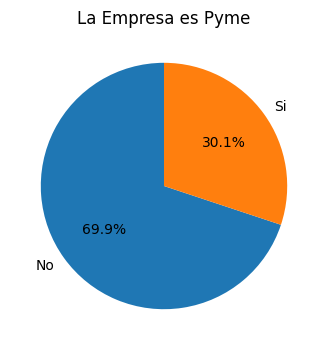

In [72]:
pyme_counts = directorio['Es Pyme'].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(pyme_counts, labels=pyme_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('La Empresa es Pyme')
plt.show()

De esta forma podemos concluir que el 30% de las empresas que están registradas en Armenia se encuentran clasificadas como PYME. 

Ahora vamos a otorgar una fecha de actualización del día de hoy.

In [73]:
hoy = date.today()
directorio['HOY'] = hoy
directorio['HOY'] = pd.to_datetime(directorio['HOY'])

Finalmente, se creará un archivo excel con esta base de datos depurada.

In [74]:
excel_path='C:\\Users\\danie\\OneDrive\\Escritorio\\Web Scraping API - CCE\\DIRECTORIO ARMENIA.xlsx'
directorio.to_excel(excel_path,sheet_name='Armenia')